## Churn Analysis with Random Forest

### Import Necessary Libraries


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Load and Preprocess the Data

In [2]:
# Load the dataset
# Load the dataset
data = pd.read_csv(r"C:\Users\Sietoyo\OneDrive\Documents\CSVs\customer_data.csv")

In [6]:
# Handle missing values if any
data.fillna(data.mean(numeric_only=True), inplace=True)

In [4]:
# Encode categorical variables
data = pd.get_dummies(data, drop_first=True)

In [5]:
# Split the data into features (X) and target (y)
X = data.drop('Churn', axis=1)
y = data['Churn']

### Split the Data into Training and Test Sets


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Train the Random Forest Model

In [8]:
# Initialize the Random Forest model with the best hyperparameters
rf_model = RandomForestClassifier(
    max_depth=20,
    min_samples_split=2,
    n_estimators=200,
    random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

### Evaluate the Model


In [9]:
# Predict probabilities and classes
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Random Forest AUC:", roc_auc)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Random Forest AUC: 0.9731863186318632
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1414
           1       0.93      0.74      0.82       275

    accuracy                           0.95      1689
   macro avg       0.94      0.87      0.90      1689
weighted avg       0.95      0.95      0.95      1689

[[1398   16]
 [  71  204]]


### Feature Importance Analysis


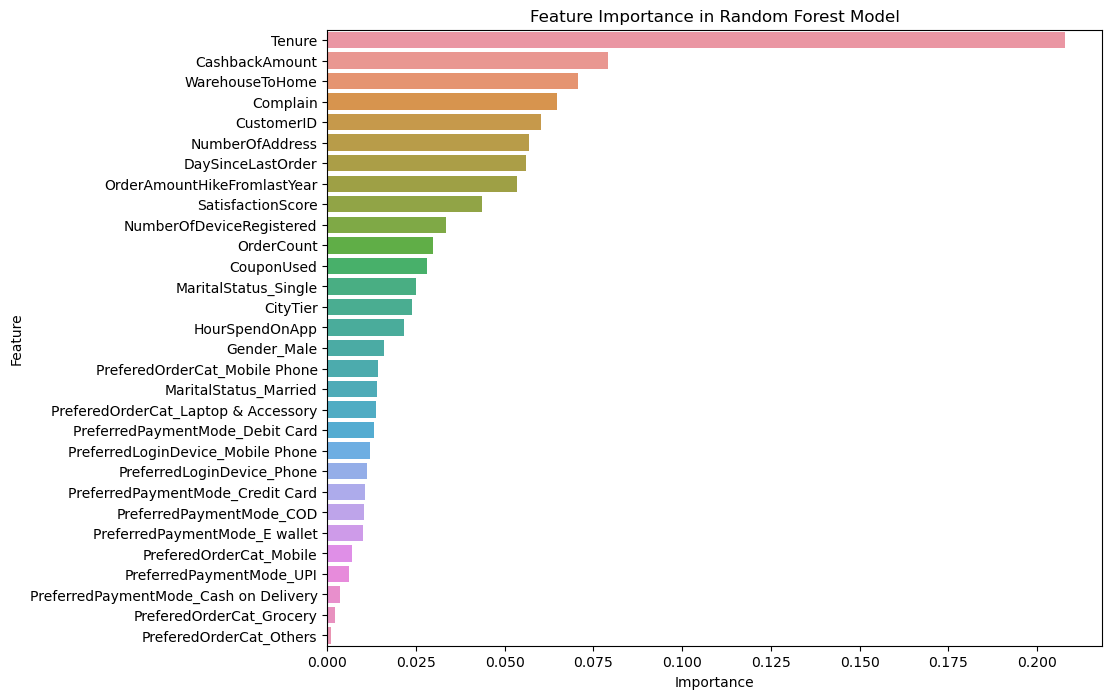

In [10]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest Model')
plt.show()


### Predict and Segment Customers by Churn Probability


In [11]:
# Predict churn probabilities for the entire dataset
data['Churn_Probability'] = rf_model.predict_proba(X)[:, 1]

# Segment customers based on churn probability
def segment_customer(prob):
    if prob > 0.75:
        return 'High Risk'
    elif prob > 0.5:
        return 'Medium Risk'
    else:
        return 'Low Risk'

data['Customer_Segment'] = data['Churn_Probability'].apply(segment_customer)

# Save the segmented data
data.to_csv('segmented_customers.csv', index=False)


### Hyperparameter Tuning


In [12]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.9716693878186493


### Retrain the Model with the Best Parameters 


In [13]:
# Initialize the Random Forest model with the best parameters
rf_model_best = RandomForestClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)

# Train the model
rf_model_best.fit(X_train, y_train)

# Evaluate the model
y_pred_best = rf_model_best.predict(X_test)
y_pred_proba_best = rf_model_best.predict_proba(X_test)[:, 1]

roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)
print("Best Random Forest AUC:", roc_auc_best)
print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))


Best Random Forest AUC: 0.972029060048862
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1414
           1       0.93      0.75      0.83       275

    accuracy                           0.95      1689
   macro avg       0.94      0.87      0.90      1689
weighted avg       0.95      0.95      0.95      1689

[[1398   16]
 [  70  205]]


### Save the Model


In [14]:
import joblib

# Save the model
joblib.dump(rf_model_best, 'random_forest_model.pkl')

# Load the model
# rf_model_loaded = joblib.load('random_forest_model.pkl')


['random_forest_model.pkl']